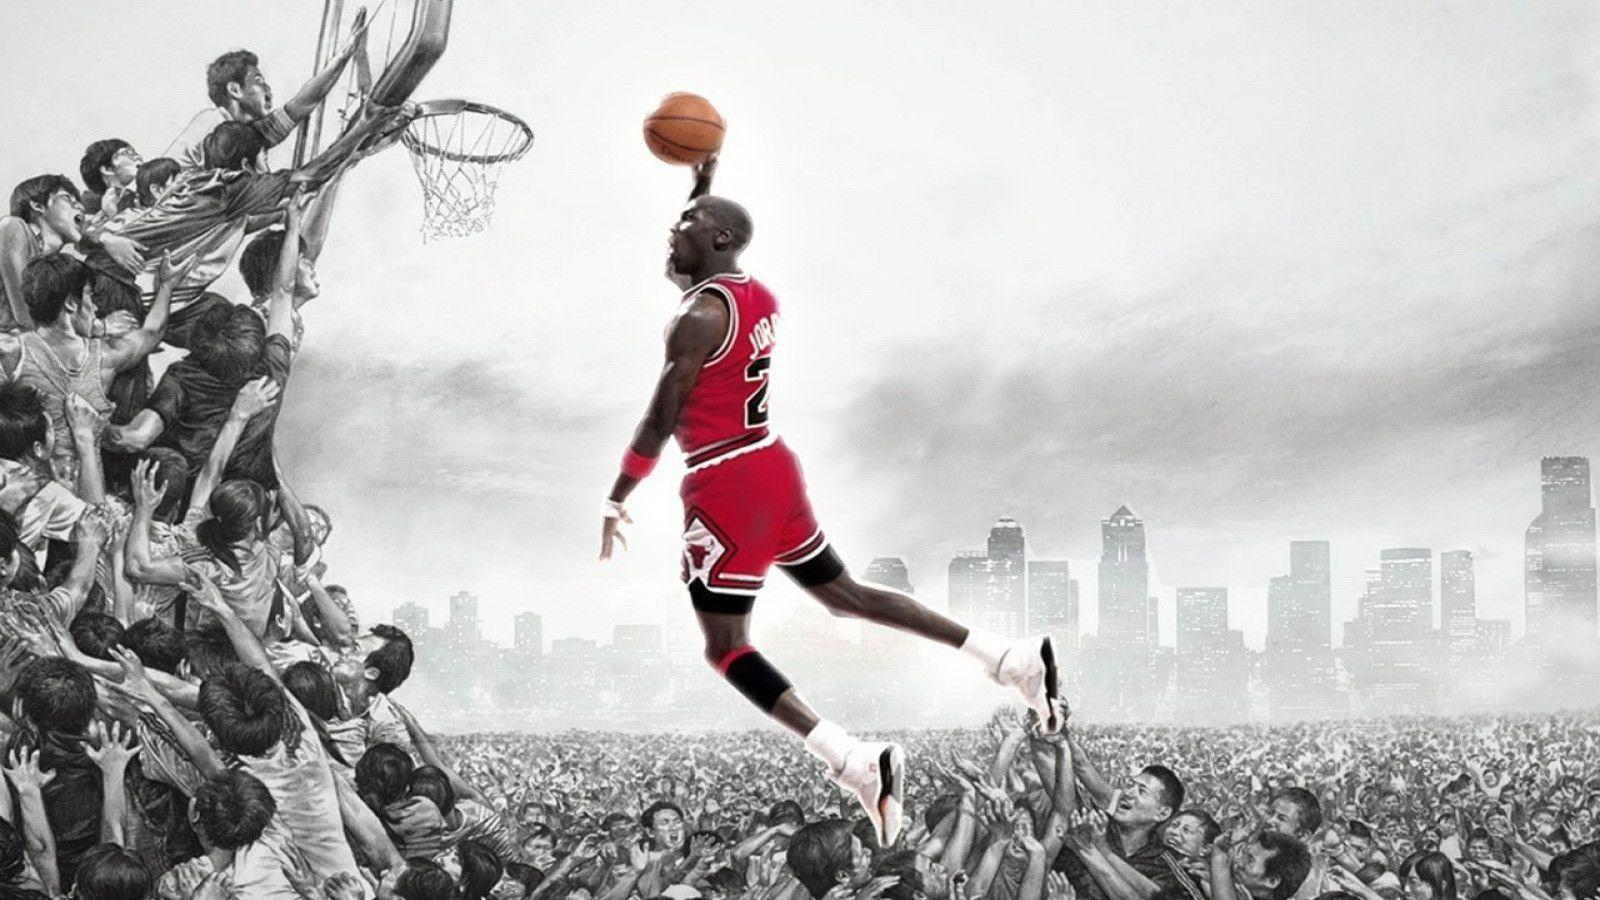

# Uma análise sobre a influencia das estatisticas dos jogadores da NBA sobre a ocorrencia de lesões
#### Por André Gadelha, Gabriel das Neves, Lucas Ferreira e Felipe Cunha 
A NBA movimenta por ano cifras bilionárias. A liga concentra os melhores jogadores do mundo, capazes de jogadas incríveis e jogos emocionantes. Mas quando se trata de dinheiro, tudo se torna apenas números. Modelos que preveem performance futura dos jogadores valem milhões, algoritmos que conseguem mensurar quanto vale cada jogador precisamente promovem uma grande economia nas equipes. Então, busco nesse trabalho analisar os dados dos jogares para obter resposta para alguns pontos:

1. Quais as estatisticas mais relevantes para determinar possiveis lesões?
2. desenvolver uma forma de prever se o jogador terá uma lesão?
3. Caracteristicas fisicas influenciam de que forma na possibilidade de lesões?

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import numpy as np

### Dataset de lesões
Neste dataset temos todas as lesões ocorridas nos ultimos anos. definimos que queremos determinar se o jogador se lesiona ou não de acordo com suas estatisticas, logo o numero de lesões no ano foi descartado.

In [9]:
df1 = pd.read_csv('/content/injuries.csv')
df1['Date'] = pd.to_datetime(df1['Date'])
df1['Ano'] = [i.year for i in df1['Date']]
df1.drop('Acquired', axis = 1, inplace = True)
df1.dropna(inplace = True)
df1.drop(['Date', 'Team', 'Notes'], axis = 1, inplace = True)
df1['Lesionado'] = 1
df1.columns = ['Player', 'Ano', 'Lesionado']
df1['Ano']+=1
df1 = df1.groupby(['Player','Ano']).count()

df1

Lesionado
Player             Ano            
 Mike Scott        2014          1
                   2015          2
                   2016          4
                   2017          3
                   2019          2
...                            ...
Zion Williamson    2020          3
                   2021          3
Zoran Dragic       2015          8
                   2016          5
Zydrunas Ilgauskas 2012          3

[4427 rows x 1 columns]

### Dataset de Velocidade dos Jogadores
Neste dataset temos todas as caracteristicas de distancia percorrida e tempo de jogo

In [10]:
df2 = pd.read_csv('/content/speed13-20.csv')
df2.columns = ['Player', 'TEAM', 'GP', 'W', 'L', 'MIN', 'DIST. FEET', 'DIST. MILES',
       'DIST. MILES OFF', 'DIST. MILES DEF', 'AVG SPEED', 'AVG SPEED OFF',
       'AVG SPEED DEF', 'Ano']

df2.head()

Player TEAM  GP   W  ...  AVG SPEED  AVG SPEED OFF AVG SPEED DEF   Ano
0    Zaza Pachulia  MIL  52  10  ...       3.94           4.01          3.86  2013
1    Zach Randolph  MEM  79  49  ...       3.88           3.90          3.85  2013
2     Xavier Henry  LAL  43  16  ...       4.49           4.82          4.20  2013
3  Wilson Chandler  DEN  62  27  ...       4.24           4.62          3.90  2013
4     Willie Green  LAC  55  38  ...       4.32           4.58          4.06  2013

[5 rows x 14 columns]

### Dataset de valores de caracteristicas fisicas
Neste dataset temos as caracteristicas fisicas dos jogadores

In [11]:
df3 = pd.read_csv('/content/bios.csv')
df3.drop(['TEAM','COLLEGE','COUNTRY','DRAFT YEAR','DRAFT NUMBER',
          'DRAFT ROUND','GP','PTS','OREB%','USG%','TS%','AST%','DREB%'], inplace = True, axis=1)

df3.head()

PLAYER  AGE HEIGHT WEIGHT  REB  AST  NETRTG   Ano
0       AJ Price   27    6/2    195   10   13     0.9  2013
1   Aaron Brooks   29    6/1    161  140  233    -2.6  2013
2     Aaron Gray   29    7/1    270  111   22   -11.1  2013
3  Adonis Thomas   21    6/7    240    3    3    17.2  2013
4  Al Harrington   34    6/9    245   80   28     4.7  2013

In [12]:
#Transformando alturas para centimentros
alturas = []
for altura in df3['HEIGHT']:
    if altura == '-':
        altura = sum(alturas)/len(alturas)
        alturas.append(altura)
        continue
    altura = altura.replace('/',' ').split()
    alturas.append(round((float(altura[0])*30.48 + float(altura[1])*2.54),0))
alturas = pd.DataFrame(alturas)
alturas.columns=['Altura']
alturas.index=df3.index
df3['Altura'] = alturas

#Transformando pesos para kilograma
weights = []
for weight in df3['WEIGHT']:
    if weight == '-':
        weight = sum(weights)/len(weights)
        weights.append(weight*0.45)
        continue
    weights.append(float(weight)*0.45)
weights = pd.DataFrame(weights)
weights.columns=['Peso']
weights.index=df3.index
df3['Peso'] = weights
df3.drop(['HEIGHT','WEIGHT'],inplace = True, axis=1)

#Formatando o Dataset
df3.columns = ['Player', 'AGE', 'REB', 'AST', 'NETRTG', 'Ano', 'Altura', 'Peso']
df3['REB'] = pd.to_numeric(df3['REB'], errors = 'coerce')



### Combinando os Datasets
Aqui vamos combinar os datasets afim de utilizarmos só um dataset.

In [13]:
data = pd.merge(df2,df1,how = 'left', on = ['Player','Ano'])
data = pd.merge(data,df3,how = 'left', on = ['Player','Ano'])
data['Lesionado'].fillna(0,inplace = True)
data['Lesão'] = [1 if i>0 else 0 for i in data['Lesionado']]
data.head()

Player TEAM  GP   W   L  ...    AST NETRTG  Altura    Peso  Lesão
0    Zaza Pachulia  MIL  52  10  42  ...  136.0   -6.4   211.0  123.75      1
1    Zach Randolph  MEM  79  49  30  ...  200.0    3.0   206.0  117.00      1
2     Xavier Henry  LAL  43  16  27  ...   51.0   -2.3   198.0   99.00      1
3  Wilson Chandler  DEN  62  27  35  ...  114.0   -4.5   203.0  101.25      1
4     Willie Green  LAC  55  38  17  ...   50.0    4.9   190.0   90.45      1

[5 rows x 22 columns]

### Drop
Agora removeremos as colunas utilizadas para fazer o merge e retiraremos dados faltantes.

In [14]:
data.drop('Lesionado', inplace= True, axis = 1)
data1 = data.drop(['Player', 'TEAM', 'W', 'L', 'DIST. MILES',
       'DIST. MILES OFF', 'DIST. MILES DEF', 'AVG SPEED OFF',
       'AVG SPEED DEF', 'Ano'], axis=1)
data1['DIST. FEET'] = pd.to_numeric(data1['DIST. FEET'], errors='coerce')
data1['DIST. FEET'].fillna(data1['DIST. FEET'].mean(), inplace = True)
data1.head()


GP   MIN  DIST. FEET  AVG SPEED   AGE  ...    AST  NETRTG  Altura    Peso  Lesão
0  52  1310    453514.0       3.94  30.0  ...  136.0    -6.4   211.0  123.75      1
1  79  2705    922134.0       3.88  32.0  ...  200.0     3.0   206.0  117.00      1
2  43   908    357114.0       4.49  23.0  ...   51.0    -2.3   198.0   99.00      1
3  62  1927    717124.0       4.24  27.0  ...  114.0    -4.5   203.0  101.25      1
4  55   869    329326.0       4.32  32.0  ...   50.0     4.9   190.0   90.45      1

[5 rows x 11 columns]

Aqui vamos considerar os jogadores com mais de 20 jogos e mais de 550 minutos jogados para validar que as lesões foram provocadas pelo jogo.

In [15]:
data_n = data1[data1['GP']>20]

In [16]:
data_n = data1[data1['MIN']>550]

## Analisando os Dados
Como forma de identificar padrões dentro dos dados usamos a matriz de correlação.

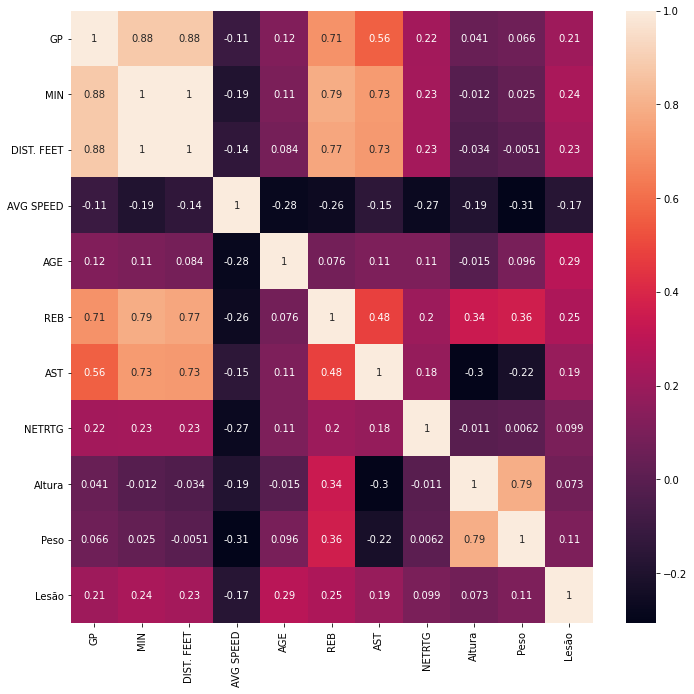

In [17]:
fig, ax = plt.subplots(figsize = (11.7, 11.27))
px.scatter_matrix(data1,
    dimensions=["GP", "MIN", "DIST. FEET", "AVG SPEED","AGE","REB","AST","NETRTG","Altura","Peso","Lesão"],
    color="Lesão")
sns.heatmap(ax = ax, data=data1.corr(), annot=True)


### Matriz de correlação
Na matriz de correlação O sinal do coeficiente de 
correlação tem como função apenas indicar se as duas variáveis se correlacionam de maneira diretamente proporcional ou inversamente proporcional. Como maior valor com a coluna lesão a coluna Idade, o que era de se esperar. Além disso os valores que chamaram atenção foram: Distância (DIST. FEET), Numero de rebotes (REB), Minutos de jogo (MIN)e quantidade de jogos jogados (GP). Essas features nos dão uma pista de valores que podem estar relacionados às lesões.

### Abordagem por classe
Separamos os datasets por classe para visualizar se temos dados separáveis ou não entre as classes. Varias analises de scatter foram feitas para determinar uma possivel separação de dados.

In [18]:
lesionados = data_n[data_n['Lesão']==1]
n_lesionados = data_n[data_n['Lesão']==0]


In [19]:
lesionados.describe()

GP          MIN    DIST. FEET  ...       Altura         Peso   Lesão
count  1795.000000  1795.000000  1.795000e+03  ...  1795.000000  1795.000000  1795.0
mean     63.391643  1607.392201  6.042892e+05  ...   200.870752    99.546017     1.0
std      13.715652   608.698219  2.229222e+05  ...     8.909867    11.542394     0.0
min      18.000000   551.000000  1.963250e+05  ...   175.000000    72.450000     1.0
25%      55.000000  1091.000000  4.164755e+05  ...   193.000000    90.000000     1.0
50%      66.000000  1601.000000  6.037190e+05  ...   201.000000    99.000000     1.0
75%      75.000000  2071.500000  7.743255e+05  ...   208.000000   108.000000     1.0
max      83.000000  3125.000000  1.175886e+06  ...   221.000000   132.750000     1.0

[8 rows x 11 columns]

In [20]:
n_lesionados.describe()

GP          MIN    DIST. FEET  ...      Altura        Peso  Lesão
count  954.000000   954.000000  9.540000e+02  ...  954.000000  954.000000  954.0
mean    64.141509  1500.267296  5.754681e+05  ...  199.794549   97.549528    0.0
std     13.768583   619.378098  2.305098e+05  ...    8.928169   10.844427    0.0
min     19.000000   553.000000  1.883510e+05  ...  175.000000   67.500000    0.0
25%     55.000000   983.250000  3.812295e+05  ...  193.000000   90.000000    0.0
50%     67.000000  1428.000000  5.532325e+05  ...  201.000000   96.750000    0.0
75%     75.750000  1978.500000  7.650885e+05  ...  206.000000  105.750000    0.0
max     83.000000  3122.000000  1.153367e+06  ...  221.000000  127.800000    0.0

[8 rows x 11 columns]

Na abordagem Geral vemos claras diferenças nas classes, não-lesionados tem menos tempo de jogo, menos partidas jogadas, menos rebotes, menos assistencias, mais jovens, performance menor e mais variável do que os lesionados. Caracteristicas como altura, peso e velocidade parece nao influenciar. O que fortalece as nossas premissas retiradas da matriz de correlação. Trabalharemos com essas features para a predição.

Ainda assim, adotar apenas essas features não contribuiu para uma acurácia aceitável. Portanto, por motivos empíricos, abordaremos todas as features.

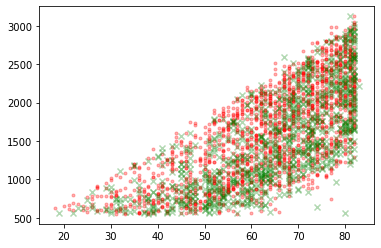

In [21]:
plt.scatter(lesionados['GP'],lesionados['MIN'], c= 'r', marker = '.',alpha=0.3);
plt.scatter(n_lesionados['GP'],n_lesionados['MIN'], c= 'g', marker = 'x',alpha=0.3);

Nesse scatter é possivel enxergar uma possivel separação de dados aparente, talvez uma algoritmo com kernels não-lineares possam dar conta dessa separabilidade.

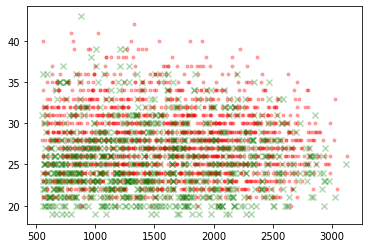

In [22]:
plt.scatter(lesionados['MIN'],lesionados['AGE'], c= 'r', marker = '.',alpha=0.3);
plt.scatter(n_lesionados['MIN'],n_lesionados['AGE'], c= 'g', marker = 'x',alpha=0.3);

Esse plot apresenta a mesma caracteristica.

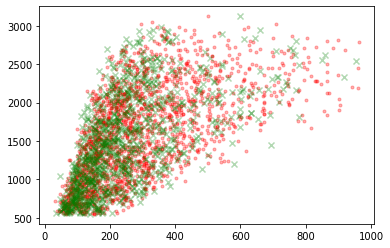

In [23]:
plt.scatter(lesionados['REB'],lesionados['MIN'], c= 'r', marker = '.',alpha=0.3);
plt.scatter(n_lesionados['REB'],n_lesionados['MIN'], c= 'g', marker = 'x',alpha=0.3);

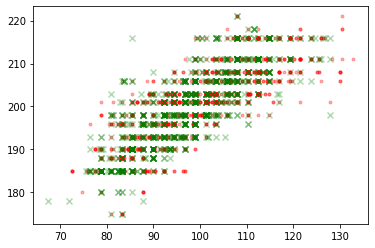

In [24]:
plt.scatter(lesionados['Peso'],lesionados['Altura'], c= 'r', marker = '.',alpha=0.3);
plt.scatter(n_lesionados['Peso'],n_lesionados['Altura'], c= 'g', marker = 'x',alpha=0.3);

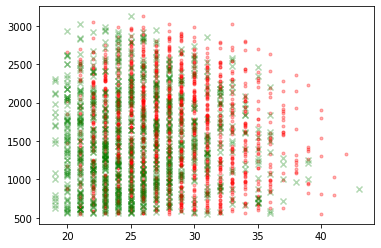

In [25]:
plt.scatter(lesionados['AGE'],lesionados['MIN'], c= 'r', marker = '.',alpha=0.3);
plt.scatter(n_lesionados['AGE'],n_lesionados['MIN'], c= 'g', marker = 'x',alpha=0.3);

Vamos verificar como andam as distribuições das nossas features

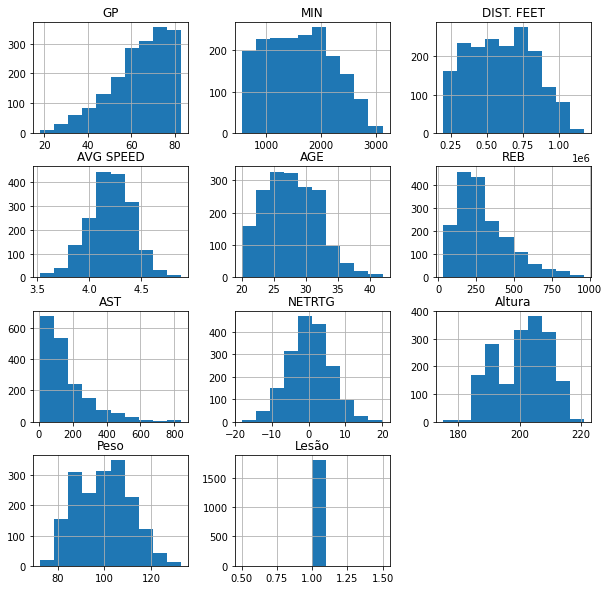

In [26]:
lesionados.hist(figsize=(10,10));

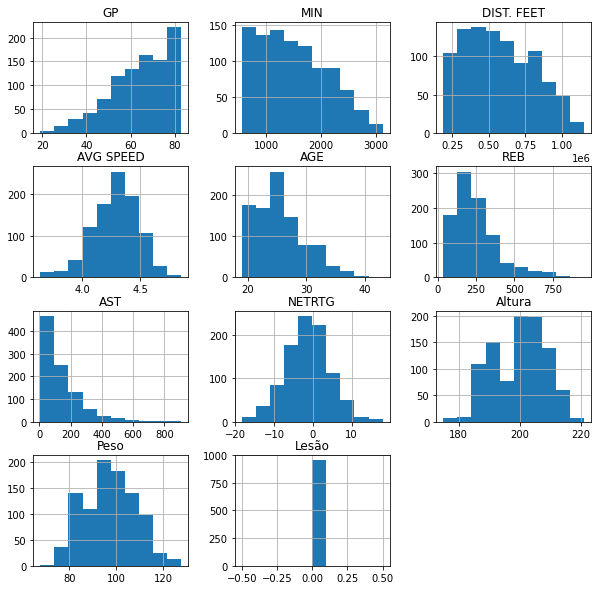

In [27]:
n_lesionados.hist(figsize=(10,10));

Vamos verificar a obliquidade dos nossos dados para decidir se será necessario a utilizações de métodos para reduzir esses valores como o BOX & COX.

In [28]:

print(scipy.stats.skew(lesionados.GP))
print(scipy.stats.skew(lesionados.MIN))
print(scipy.stats.skew(lesionados["DIST. FEET"]))
print(scipy.stats.skew(lesionados.REB, nan_policy= 'omit'))


-0.73688314593315
0.14586408798786837
0.10690374479149695
1.1394563902402803


Os valores de obliquidade permaneceram proximos de zero. O que nos diz que os dados estão simétricos.

O próximo passo é a elaboração dos modelos.

## Modelos

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectPercentile,f_regression
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression,SGDClassifier
import sklearn.metrics as metrics
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier

Divisão em treino e teste

In [30]:
y = data_n[['Lesão']]
x = data_n.drop('Lesão',axis=1)
x = x.fillna(0)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=2)
#checando:
X_train

GP   MIN  DIST. FEET  AVG SPEED  ...    AST  NETRTG  Altura    Peso
50    76  1948    700952.0       4.10  ...  119.0     1.5   206.0   96.75
175   81  2153    716573.0       3.80  ...  144.0     3.4   208.0  110.25
2994  43  1133    454766.0       4.24  ...   46.0     0.3   198.0   95.40
1171  76  2804    989967.0       4.02  ...  494.0     6.4   185.0   92.25
1091  66  1313    490994.0       4.27  ...   38.0    -5.9   198.0  103.50
...   ..   ...         ...        ...  ...    ...     ...     ...     ...
3717  56  1499    587164.0       4.23  ...  202.0    -4.9   211.0  114.30
3449  57  1420    551063.0       4.12  ...  262.0     1.5   180.0   82.35
2311  65  1615    613781.0       4.35  ...  124.0    -7.4   198.0   87.75
3759  54   904    377260.0       4.47  ...  124.0     0.8   185.0   76.50
3812  62  1755    645025.0       4.01  ...  112.0     3.8   211.0  119.25

[2061 rows x 10 columns]

## KNN


O vizinho mais próximo (KNN) é um algoritmo de aprendizado de máquina muito simples, fácil de entender, versátil e um dos mais avançados.

"O princípio por trás dos métodos de vizinho mais próximo é encontrar um número predefinido de amostras de treinamento mais próximas em distância do novo ponto e prever o rótulo a partir deles. O número de amostras pode ser uma constante definida pelo usuário (aprendizado de k-vizinho mais próximo), ou variam com base na densidade local de pontos (aprendizagem de vizinhos com base no raio). "

In [31]:
n_neighbors =10
clf = KNeighborsClassifier(n_neighbors=n_neighbors)
clf.fit(X_train,y_train.values.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [32]:
y_pred = clf.predict(X_test)
print(y_pred)
clf.score(X_test, y_test)

[0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 0
 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 0 1 0 0 0 1 0 1 1 1 0 1 1 1
 1 1 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 0 0
 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0
 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 0 0
 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 0 1 1
 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1
 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1
 1 1 0 1 1 1 0 0 1 1 1 1 

0.5857558139534884

In [33]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.38      0.27      0.31       244
           1       0.65      0.76      0.70       444

    accuracy                           0.59       688
   macro avg       0.52      0.51      0.51       688
weighted avg       0.56      0.59      0.57       688



## SVM

O objetivo deste algoritmo é encontrar o melhor Hiperplano que divide os dados em dois grupos.

Os "vetores de suporte" são simplesmente as coordenadas do indivíduo em observação. Support Vector Machine é um limite que melhor segregam as duas classes (hiperplano / linha). Os "vetores de suporte" são simplesmente as coordenadas do indivíduo em observação. Support Vector Machine é um limite que melhor segregam as duas classes (hiperplano / linha).


In [34]:

clf2 = svm.SVC() # definindo o classificador, aqui podemos escolher se vai usar uma abordagem linear
 # ou polinomial, etc pelo parâmetro do kernel
 # ex: svm.SVC(kernel='poly')
clf2.fit(X_train,y_train.values.ravel()) # treinando o classificador

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [35]:
clf2.predict(X_test) #testando

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [36]:
clf2.score(X_test, y_test) # conferindo a acurácia

0.6453488372093024

## Árvore de decisão

A partir da escolha do nó raiz a árvore de decisão decide dividindo-se em nós. A divisão é baseada em métricas pelas suas métricas.

Apesar de serem algoritimos instáveis às mudanças nos dados, as árvores de decisão são simples de compreender e de implementar.

Em contraste aos modelos lineares, elas mapeiam muito bem relações não-lineares, que seria o nosso caso já que utilizaremos todas não apenas as features da matriz de correlação, mas tambem as com relações pouco lineares como mostrado na sessão de Abordagem por Classe nos scatter-plots.

In [37]:
pipe_tree = make_pipeline(MinMaxScaler(),
                        SelectPercentile(f_regression, percentile=70),
                        PolynomialFeatures(2),
                        tree.DecisionTreeClassifier())
pipe_tree.fit(X_train, y_train)
y_pred = pipe_tree.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

0.6191860465116279
              precision    recall  f1-score   support

           0       0.46      0.42      0.44       244
           1       0.70      0.73      0.71       444

    accuracy                           0.62       688
   macro avg       0.58      0.57      0.57       688
weighted avg       0.61      0.62      0.61       688



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



## Regressão logística

Algoritimo de classificação baseado na probabilidade de propriedade de classe, ou seja, ele prevê a probabilidade do valor categórico de um input.

Mostrar os resultados em forma de probabilidades é uma vantagem em usar essa tipo de regressão, além disso, a regressão logística, tem alto grau de confiabilidade.

In [38]:
pipe_lrc = make_pipeline(MinMaxScaler(),
                        SelectPercentile(f_regression, percentile=77),
                        PolynomialFeatures(2),
                        LogisticRegression(penalty='elasticnet',solver='saga',max_iter=20000,l1_ratio=0.2))
pipe_lrc.fit(X_train, y_train.values.ravel())
y_pred = pipe_lrc.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

0.7093023255813954
              precision    recall  f1-score   support

           0       0.68      0.34      0.45       244
           1       0.72      0.91      0.80       444

    accuracy                           0.71       688
   macro avg       0.70      0.63      0.63       688
weighted avg       0.70      0.71      0.68       688



In [65]:
X_test

GP   MIN  DIST. FEET  AVG SPEED  ...    AST  NETRTG  Altura    Peso
660   70  1587    581340.0       4.17  ...  293.0     9.8   198.0   92.25
3006  50   646    266857.0       4.35  ...   87.0     7.0   185.0   83.25
1316  72  2125    857837.0       4.60  ...  467.0    -1.4   193.0   83.25
2517  51   720    292927.0       4.32  ...   80.0    -0.3   201.0   96.75
3421  65  1656    722203.0       4.68  ...  271.0    -4.2   193.0   81.00
...   ..   ...         ...        ...  ...    ...     ...     ...     ...
2317  79  2034    751515.0       4.21  ...  173.0    -1.1   201.0   99.00
3058  46  1147    445678.0       4.15  ...   83.0    -6.6   208.0  111.60
3398  69  2079    827671.0       4.24  ...  114.0     6.5   201.0   99.00
1827  71  1860    678973.0       4.16  ...   74.0     2.8   203.0   95.40
4001  60  1453    585866.0       4.26  ...   63.0     3.8   206.0   90.00

[688 rows x 10 columns]

## Escolha do Modelo

Dentre os modelos treinados e de acordo com suas acurácias para ambos os grupos lesionados e não-lesionados, o modelo que performou melhor foi o de regressão logística com parametro de penalidade penalidade elasticnet, mas também obtivemos resultados próximos como no modelo de Árvore de Decisão. mesmo assim, diante do alto grau de confiabilidade de uma regressão logística bem como pelo fato de usar probabilidades, escolhemos este como o modelo a ser utilizado.


## Teste de caso

Tendo em vista o estudo apresentado àcima, propomo-nos a fazer um teste em uma situação real. Analisando o Caso do jogador Luís gruber, que sofreu uma lesão no segundo quarto do jogo entre Mogi e Quimsa pela Champions league, em Janeiro de 2020. Ao obter todas as informações relevantes sobre Luis para que possamos aplicar seus dados no algorítmo aqui desenvolvido, temos que:

In [67]:
rebotes = 1075.0
jogos = 310
altura = 201
peso = 111
velMedia = 4.23
distPes = 596529.0
min = 7904.0
ast = 379
idade = 36
netrtg = 0.25

In [75]:
luis = [[jogos, min, distPes, velMedia, idade, rebotes, ast, netrtg, altura, peso]]
print(luis)
y_pred = pipe_lrc.predict(luis)
print(y_pred)

[[310, 7904.0, 596529.0, 4.23, 36, 1075.0, 379, 0.25, 201, 111]]
[1]


Como podemos ver, o algorítmo conseguiu prever perfeitamente a lesão do jogador.

## Conclusão

Ao longo deste trabalho nos debruçamos sobre o banco de dados da NBA, portanto não tão abrangente, para investigar os seguintes pontos:

1. Quais as estatisticas mais relevantes para determinar possiveis lesões?
2. Desenvolver uma forma de prever se o jogador terá uma lesão.
3. Caracteristicas fisicas influenciam de que forma na possibilidade de lesões?

Baseado nas abordagens deste projeto, as estatísticas mais relevantes para possíveis lesões são:  Distância percorrida, Numero de rebotes, Minutos de jogo, idade e quantidade de jogos jogados.

Diante das estratégias de EDA desenvolvidas e discutidas aqui, a forma que desenvolvemos para prever lesões foi por meio do algoritimo de Regressão Logística, como discutido anteriormente.

Por fim, Surpreendentemente, as características físicas não são as que mais influenciam nas lesões. Discutimos esse resultado e desconfiamos que isso se deve ao fato de serem atletas com preparo físico para aguentarem os seus pesos, ou seja, há um preparo muscular para aguetarem bem a aterrisagem em um rebote, etc. 

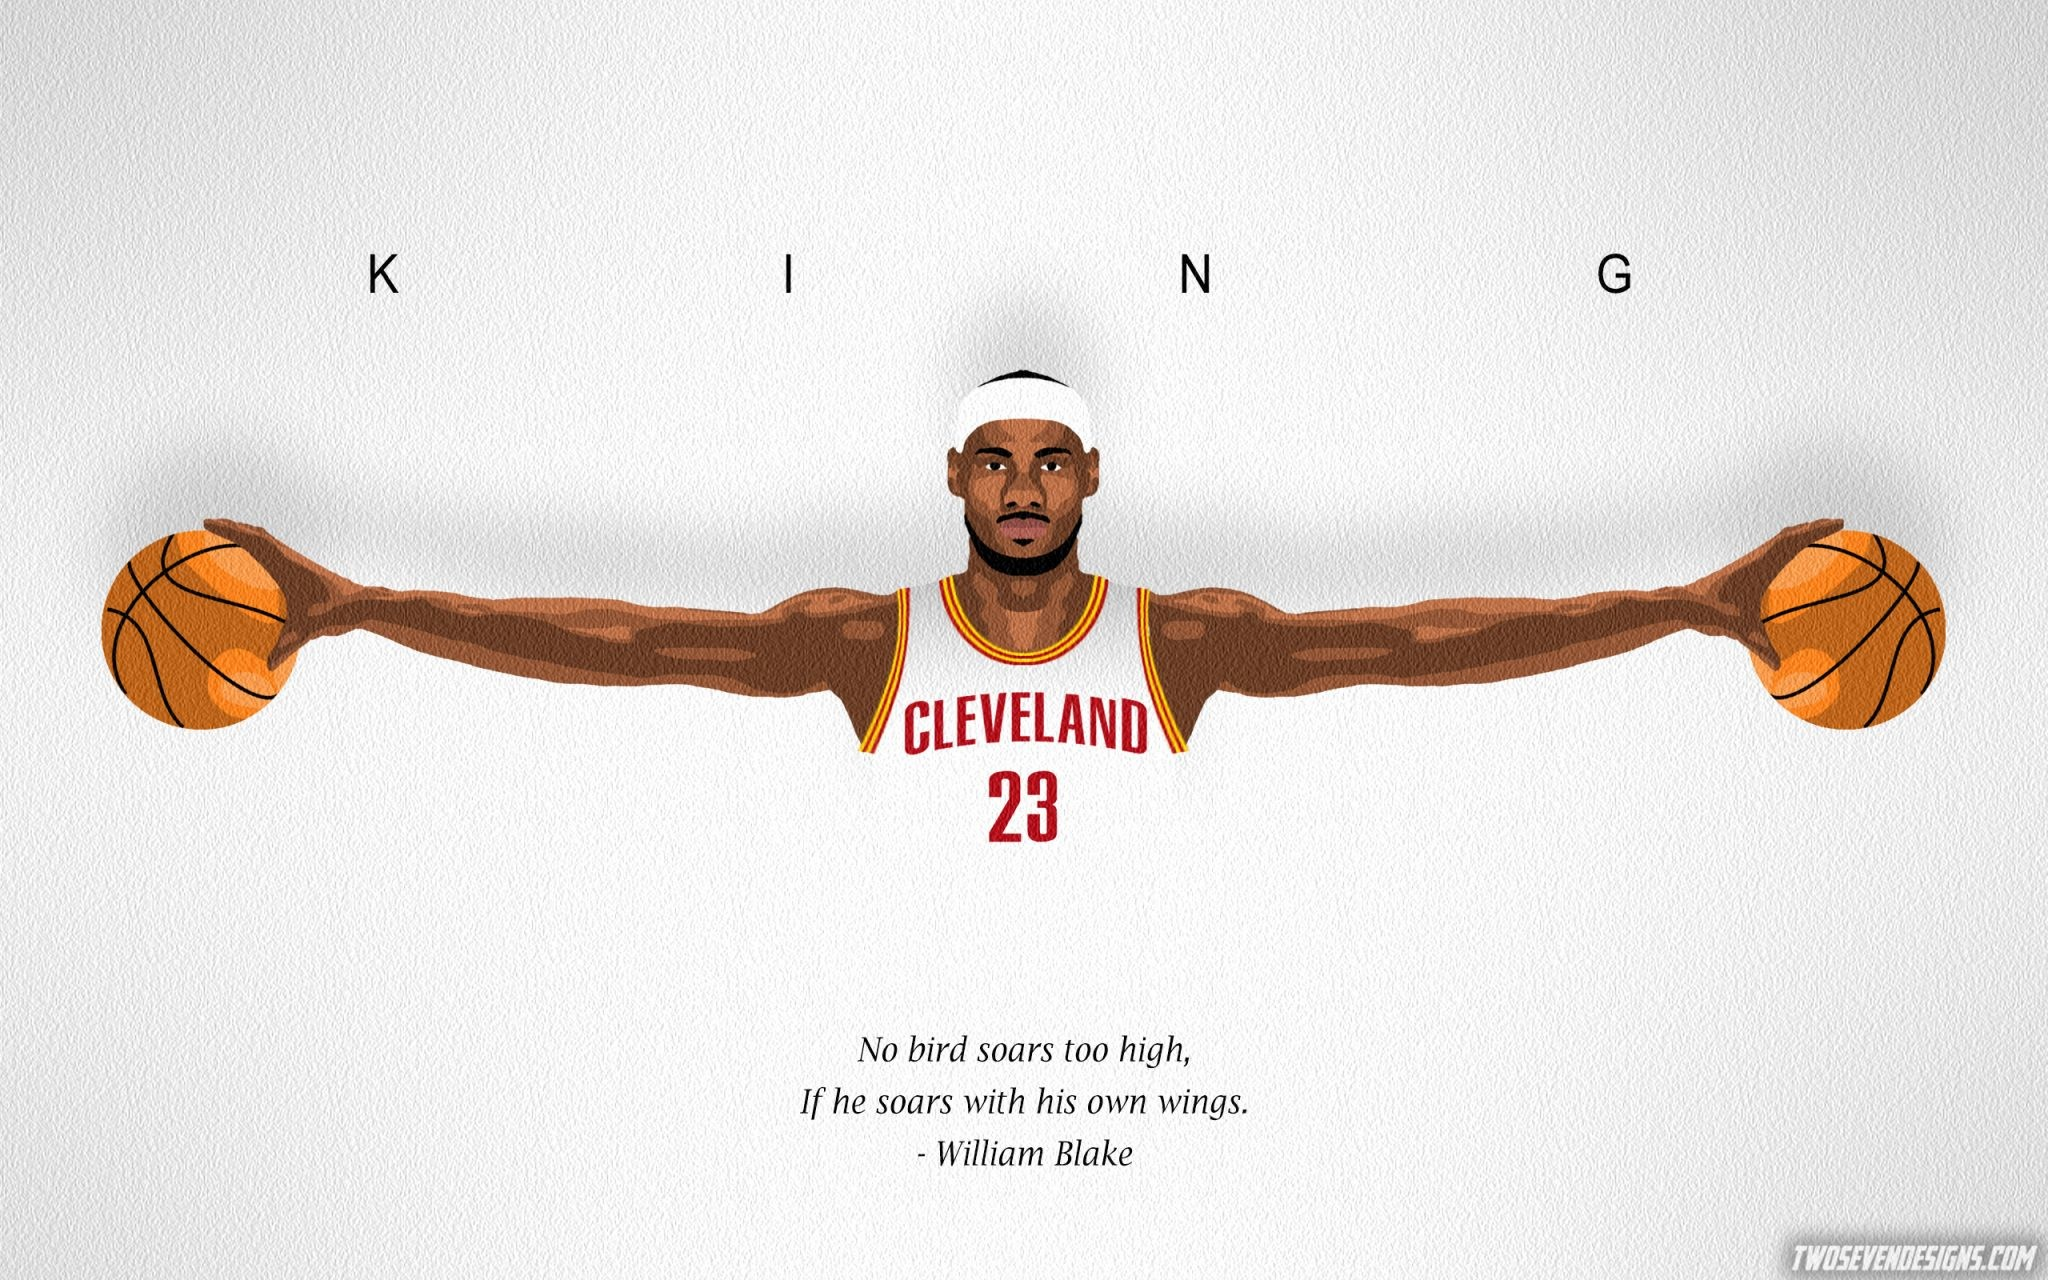